## Renko chart Strategy


### Renko chart is a chart itself that came from Japan where renki means bricks
###  It only form a brick in the chart when a stock moves by a dollar or custome value amount
### Buy the stock when three consecutive green bricks are formed and sell when two consecutive bricks are formed

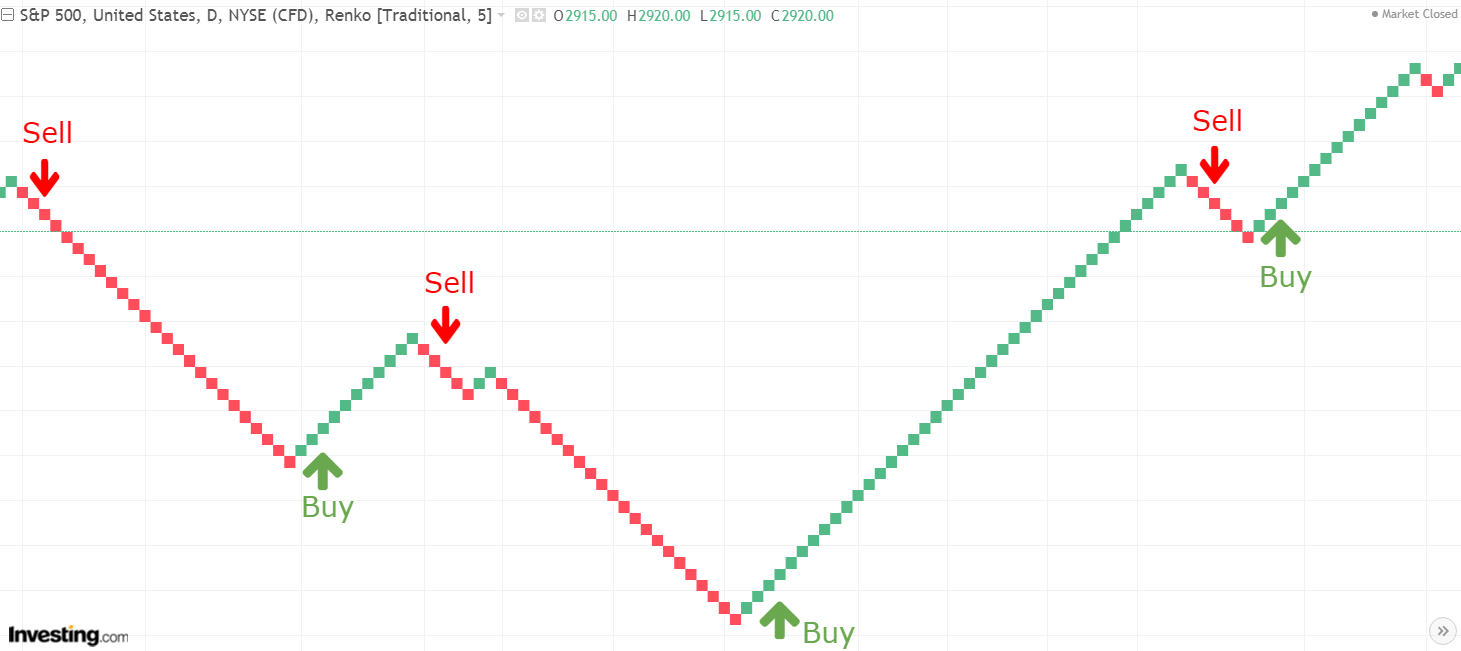

In [114]:
import numpy as np
import pandas as pd
import copy
import time
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from stocktrends import Renko

In [115]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

In [116]:
def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

In [117]:
def renko_DF(DF,brick_size):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    #df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    df2.brick_size = brick_size
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

In [118]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [119]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)  #252 trading days #252*6.5 trading hours #252*6.5*12 (5mins)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

In [120]:
def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)  #252 as it is day candle stick #52 if it is week candle stick
    return vol

In [121]:
def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

In [122]:
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [123]:
ticker='TSLA'
stock=yf.download(ticker,period='60d',interval='5m')

[*********************100%***********************]  1 of 1 completed


In [124]:
stock

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-09-29 09:30:00-04:00,282.898499,283.649994,282.029999,282.101898,282.101898,3397387
2022-09-29 09:35:00-04:00,281.000000,281.109985,279.635803,279.823303,279.823303,1641859
2022-09-29 09:40:00-04:00,279.429993,279.609985,276.604614,276.799988,276.799988,1991683
2022-09-29 09:45:00-04:00,276.750000,278.269989,276.059998,276.059998,276.059998,1606730
2022-09-29 09:50:00-04:00,276.000000,277.489990,275.850006,276.299988,276.299988,1696370
...,...,...,...,...,...,...
2022-12-22 11:20:00-05:00,128.710007,129.369995,128.552307,129.080002,129.080002,1477388
2022-12-22 11:25:00-05:00,129.080002,129.729996,128.934097,129.485001,129.485001,2195445
2022-12-22 11:30:00-05:00,129.479996,129.589996,128.720001,128.955093,128.955093,2056410


<AxesSubplot:xlabel='Datetime'>

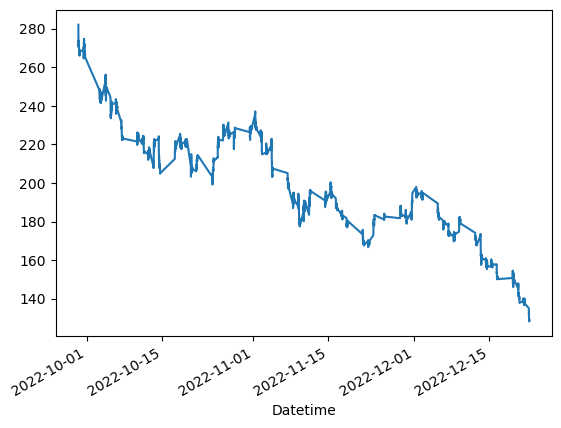

In [125]:
stock["Adj Close"].plot()

In [126]:
renko=renko_DF(stock,brick_size=0.50)
renko

/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12802/3407483437.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12802/3407483437.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]


,date,open,high,low,close,uptrend,bar_num
0,2022-09-29 09:30:00-04:00,281.5,282.0,281.5,282.0,True,1
3,2022-09-29 09:35:00-04:00,280.5,280.5,280.0,280.0,False,-3
9,2022-09-29 09:40:00-04:00,277.5,277.5,277.0,277.0,False,-9
10,2022-09-29 09:45:00-04:00,277.0,277.0,276.5,276.5,False,-10
11,2022-09-29 09:55:00-04:00,276.5,276.5,276.0,276.0,False,-11
...,...,...,...,...,...,...,...
2611,2022-12-22 10:20:00-05:00,132.5,132.5,132.0,132.0,False,-15
2612,2022-12-22 10:25:00-05:00,132.0,132.0,131.5,131.5,False,-16
2614,2022-12-22 10:30:00-05:00,131.0,131.0,130.5,130.5,False,-18
2616,2022-12-22 10:35:00-05:00,130.0,130.0,129.5,129.5,False,-20


In [127]:
renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
stock["Date"] = stock.index
stock = stock.merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
stock["bar_num"].fillna(method='ffill',inplace=True)

In [128]:
stock.index=stock.Date
stock

,Open,High,Low,Close,Adj Close,Volume,Date,bar_num
Date,,,,,,,,
2022-09-29 09:30:00-04:00,282.898499,283.649994,282.029999,282.101898,282.101898,3397387,2022-09-29 09:30:00-04:00,1.0
2022-09-29 09:35:00-04:00,281.000000,281.109985,279.635803,279.823303,279.823303,1641859,2022-09-29 09:35:00-04:00,-3.0
2022-09-29 09:40:00-04:00,279.429993,279.609985,276.604614,276.799988,276.799988,1991683,2022-09-29 09:40:00-04:00,-9.0
2022-09-29 09:45:00-04:00,276.750000,278.269989,276.059998,276.059998,276.059998,1606730,2022-09-29 09:45:00-04:00,-10.0
2022-09-29 09:50:00-04:00,276.000000,277.489990,275.850006,276.299988,276.299988,1696370,2022-09-29 09:50:00-04:00,-10.0
...,...,...,...,...,...,...,...,...
2022-12-22 11:20:00-05:00,128.710007,129.369995,128.552307,129.080002,129.080002,1477388,2022-12-22 11:20:00-05:00,-22.0
2022-12-22 11:25:00-05:00,129.080002,129.729996,128.934097,129.485001,129.485001,2195445,2022-12-22 11:25:00-05:00,-22.0
2022-12-22 11:30:00-05:00,129.479996,129.589996,128.720001,128.955093,128.955093,2056410,2022-12-22 11:30:00-05:00,-22.0


In [129]:
stock["atr"]=ATR(stock,120)["ATR"]

In [130]:
def gain_plot_combination_return(buy_value,sell_value):
    signal_list=[]
    signal=""
    return_list=[]
    stoploss_list=[]
    capital_list=[]
    capital=500
    for i in range(len(stock)):
        if stock.index[i].hour==15 and stock.index[i].minute==55:
            if signal=="Buy Call":
                signal_list.append("Sell")
                signal=""
                return_list.append(stock["Close"][i]-cost)
                stoploss_list.append(0)
            elif signal=="Buy Put":
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-stock["Close"][i])
                stoploss_list.append(0)
            elif signal=="":
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(0)
        #update       
#         elif stock.index[i].hour=9 and stock.index[i].minute<=55:
#             signal_list.append("")
#             return_list.append(0)
#             stoploss_list.append(0)
            
        elif signal=="":
            if stock["bar_num"][i]>=buy_value:
                signal="Buy Call"
                signal_list.append(signal)
                cost=stock["Close"][i]
                stoploss=cost-stock["atr"][i]
                return_list.append(0)
                stoploss_list.append(stoploss)

            elif stock["bar_num"][i]<=sell_value:
                signal="Buy Put"
                signal_list.append(signal)
                cost=stock["Close"][i]
                stoploss=cost+stock["atr"][i]
                return_list.append(0)
                stoploss_list.append(stoploss)
            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(0)
        elif signal=="Buy Call":
            #sell signal
            if stock["bar_num"][i]<=-2:
                signal_list.append("Sell")
                signal=""
                return_list.append(stock["Close"][i]-cost)
                stoploss_list.append(0)
            elif stock["Close"][i]<stoploss:
                signal_list.append("Sell")
                signal=""
                return_list.append(stock["Close"][i]-cost)
                stoploss_list.append(stoploss)

            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(stoploss)

        elif signal=="Buy Put":
            #sell signal
            if stock["bar_num"][i]>=2:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-stock["Close"][i])
                stoploss_list.append(0)
            elif stock["Close"][i]>stoploss:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-stock["Close"][i])
                stoploss_list.append(stoploss)
            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(stoploss)
        capital=capital+return_list[-1]*50
        capital_list.append(capital)
    stock["capital"]=capital_list
    #return_list=return_list[:-1]
    stock["signal"]=signal_list
    stock["return"]=return_list
    stock["stop_loss"]=stoploss_list
    stock["return_dollar"]=stock["return"]*50
    stock['cum_return']=stock['return'].cumsum()
    stock["cum_return_dollar"]=stock["return_dollar"].cumsum()
    stock["ret"]=stock["capital"].pct_change().fillna(0)
    #stock['cum_return']=stock['return'].cumsum()
    return stock

In [131]:
def gain_plot_no_stoploss(buy_value,sell_value):
    signal_list=[]
    signal=""
    return_list=[]
    
    for i in range(len(stock)):
        if stock.index[i].hour==15 and stock.index[i].minute==57:
            if signal=="Buy Call":
                signal_list.append("Sell")
                signal=""
                return_list.append(stock["Close"][i]-cost)
            elif signal=="Buy Put":
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-stock["Close"][i])
            elif signal=="":
                signal_list.append("")
                return_list.append(0)
        elif signal=="":
            if stock["bar_num"][i]>=buy_value:
                signal="Buy Call"
                signal_list.append(signal)
                cost=stock["Close"][i]
                return_list.append(0)
            elif stock["bar_num"][i]<=sell_value:
                signal="Buy Put"
                signal_list.append(signal)
                cost=stock["Close"][i]
                return_list.append(0)
            else:
                signal_list.append("")
                return_list.append(0)
        elif signal=="Buy Call":
            #sell signal
            if stock["bar_num"][i]<=-2:
                signal_list.append("Sell")
                signal=""
                return_list.append(stock["Close"][i]-cost)
            else:
                signal_list.append("")
                return_list.append(0)

        elif signal=="Buy Put":
            #sell signal
            if stock["bar_num"][i]>=2:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-stock["Close"][i])
            else:
                signal_list.append("")
                return_list.append(0)
    
    stock["signal"]=signal_list
    stock["return"]=return_list
    stock['cum_return']=stock['return'].cumsum()
    stock["return_dollar"]=stock["return"]*50
    stock["cum_return_dollar"]=stock["return_dollar"].cumsum()
    
    
    return stock

In [132]:
gain_plot_combination_return(buy_value=3,sell_value=-3)['2022-12-19']#.to_csv("today_result.csv")

/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12802/2486957206.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  gain_plot_combination_return(buy_value=3,sell_value=-3)['2022-12-19']#.to_csv("today_result.csv")


,Open,High,Low,Close,Adj Close,Volume,Date,bar_num,atr,capital,signal,return,stop_loss,return_dollar,cum_return,cum_return_dollar,ret
Date,,,,,,,,,,,,,,,,,
2022-12-19 09:30:00-05:00,154.000000,154.130005,150.500000,150.770004,150.770004,11000031,2022-12-19 09:30:00-05:00,-1.0,0.729269,-507.475281,,0.000000,0.000000,0.000000,-20.149506,-1007.475281,0.000000
2022-12-19 09:35:00-05:00,150.809998,152.559998,150.330002,152.229996,152.229996,3251537,2022-12-19 09:35:00-05:00,2.0,0.738936,-507.475281,,0.000000,0.000000,0.000000,-20.149506,-1007.475281,0.000000
2022-12-19 09:40:00-05:00,152.220001,154.660004,151.899994,154.589996,154.589996,3526444,2022-12-19 09:40:00-05:00,7.0,0.755133,-507.475281,Buy Call,0.000000,153.834864,0.000000,-20.149506,-1007.475281,0.000000
2022-12-19 09:45:00-05:00,154.625397,155.250000,153.380005,153.920105,153.920105,3786125,2022-12-19 09:45:00-05:00,7.0,0.766467,-507.475281,,0.000000,153.834864,0.000000,-20.149506,-1007.475281,0.000000
2022-12-19 09:50:00-05:00,153.955002,154.199997,152.589996,152.889999,152.889999,2254514,2022-12-19 09:50:00-05:00,-2.0,0.774968,-592.475128,Sell,-1.699997,0.000000,-84.999847,-21.849503,-1092.475128,0.167496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19 15:35:00-05:00,150.000000,150.419998,149.259995,149.287506,149.287506,1570542,2022-12-19 15:35:00-05:00,-1.0,0.821778,-376.755524,,0.000000,151.650839,0.000000,-17.535110,-876.755524,0.000000
2022-12-19 15:40:00-05:00,149.270096,149.740005,149.139999,149.279999,149.279999,1602713,2022-12-19 15:40:00-05:00,-1.0,0.822446,-376.755524,,0.000000,151.650839,0.000000,-17.535110,-876.755524,0.000000
2022-12-19 15:45:00-05:00,149.270004,149.600006,149.179993,149.345001,149.345001,1274571,2022-12-19 15:45:00-05:00,-1.0,0.818030,-376.755524,,0.000000,151.650839,0.000000,-17.535110,-876.755524,0.000000


/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_12802/2946764766.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  gain_plot_combination_return(buy_value=-3,sell_value=3)['2022-12']['capital'].plot()


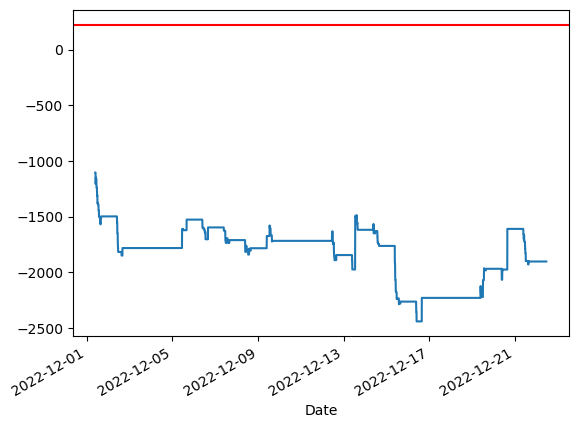

In [133]:
gain_plot_combination_return(buy_value=-3,sell_value=3)['2022-12']['capital'].plot()
plt.axhline(y=225,color='r',linestyle='-')

In [134]:
gain_plot_combination_return(buy_value=3,sell_value=-3)#.to_csv("renko_capital_gain.csv")

,Open,High,Low,Close,Adj Close,Volume,Date,bar_num,atr,capital,signal,return,stop_loss,return_dollar,cum_return,cum_return_dollar,ret
Date,,,,,,,,,,,,,,,,,
2022-09-29 09:30:00-04:00,282.898499,283.649994,282.029999,282.101898,282.101898,3397387,2022-09-29 09:30:00-04:00,1.0,NaN,500.000000,,0.0,0.000000,0.0,0.0000,0.000000,0.0
2022-09-29 09:35:00-04:00,281.000000,281.109985,279.635803,279.823303,279.823303,1641859,2022-09-29 09:35:00-04:00,-3.0,NaN,500.000000,Buy Put,0.0,NaN,0.0,0.0000,0.000000,0.0
2022-09-29 09:40:00-04:00,279.429993,279.609985,276.604614,276.799988,276.799988,1991683,2022-09-29 09:40:00-04:00,-9.0,NaN,500.000000,,0.0,NaN,0.0,0.0000,0.000000,0.0
2022-09-29 09:45:00-04:00,276.750000,278.269989,276.059998,276.059998,276.059998,1606730,2022-09-29 09:45:00-04:00,-10.0,NaN,500.000000,,0.0,NaN,0.0,0.0000,0.000000,0.0
2022-09-29 09:50:00-04:00,276.000000,277.489990,275.850006,276.299988,276.299988,1696370,2022-09-29 09:50:00-04:00,-10.0,NaN,500.000000,,0.0,NaN,0.0,0.0000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 11:20:00-05:00,128.710007,129.369995,128.552307,129.080002,129.080002,1477388,2022-12-22 11:20:00-05:00,-22.0,0.819055,-409.095001,,0.0,135.891849,0.0,-18.1819,-909.095001,0.0
2022-12-22 11:25:00-05:00,129.080002,129.729996,128.934097,129.485001,129.485001,2195445,2022-12-22 11:25:00-05:00,-22.0,0.823687,-409.095001,,0.0,135.891849,0.0,-18.1819,-909.095001,0.0
2022-12-22 11:30:00-05:00,129.479996,129.589996,128.720001,128.955093,128.955093,2056410,2022-12-22 11:30:00-05:00,-22.0,0.827937,-409.095001,,0.0,135.891849,0.0,-18.1819,-909.095001,0.0


In [135]:
gain_plot_no_stoploss(buy_value=-3,sell_value=3)

,Open,High,Low,Close,Adj Close,Volume,Date,bar_num,atr,capital,signal,return,stop_loss,return_dollar,cum_return,cum_return_dollar,ret
Date,,,,,,,,,,,,,,,,,
2022-09-29 09:30:00-04:00,282.898499,283.649994,282.029999,282.101898,282.101898,3397387,2022-09-29 09:30:00-04:00,1.0,NaN,500.000000,Buy Call,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2022-09-29 09:35:00-04:00,281.000000,281.109985,279.635803,279.823303,279.823303,1641859,2022-09-29 09:35:00-04:00,-3.0,NaN,500.000000,Sell,-2.278595,NaN,-113.929749,-2.278595,-113.929749,0.0
2022-09-29 09:40:00-04:00,279.429993,279.609985,276.604614,276.799988,276.799988,1991683,2022-09-29 09:40:00-04:00,-9.0,NaN,500.000000,Buy Put,0.000000,NaN,0.000000,-2.278595,-113.929749,0.0
2022-09-29 09:45:00-04:00,276.750000,278.269989,276.059998,276.059998,276.059998,1606730,2022-09-29 09:45:00-04:00,-10.0,NaN,500.000000,,0.000000,NaN,0.000000,-2.278595,-113.929749,0.0
2022-09-29 09:50:00-04:00,276.000000,277.489990,275.850006,276.299988,276.299988,1696370,2022-09-29 09:50:00-04:00,-10.0,NaN,500.000000,,0.000000,NaN,0.000000,-2.278595,-113.929749,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 11:20:00-05:00,128.710007,129.369995,128.552307,129.080002,129.080002,1477388,2022-12-22 11:20:00-05:00,-22.0,0.819055,-409.095001,,0.000000,135.891849,0.000000,-136.907394,-6845.369720,0.0
2022-12-22 11:25:00-05:00,129.080002,129.729996,128.934097,129.485001,129.485001,2195445,2022-12-22 11:25:00-05:00,-22.0,0.823687,-409.095001,,0.000000,135.891849,0.000000,-136.907394,-6845.369720,0.0
2022-12-22 11:30:00-05:00,129.479996,129.589996,128.720001,128.955093,128.955093,2056410,2022-12-22 11:30:00-05:00,-22.0,0.827937,-409.095001,,0.000000,135.891849,0.000000,-136.907394,-6845.369720,0.0


In [136]:

x=gain_plot_no_stoploss(buy_value=-3,sell_value=3)
call_count=0
put_count=0
for i in range(len(x)):
    if x["signal"][i]=="Buy Call":
        call_count=call_count+1
    elif x["signal"][i]=="Buy Put":
        put_count=put_count+1
print("call_count: ",call_count)
print("put_count",put_count)
print(call_count+put_count)

call_count:  452
put_count 106
558


Text(0, 0.5, 'Cummulative Gain in $')

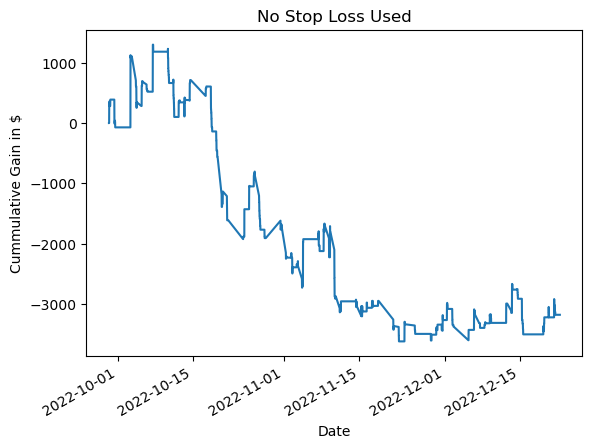

In [137]:
gain_plot_no_stoploss(buy_value=3,sell_value=-3)['cum_return_dollar'].plot()
plt.title('No Stop Loss Used')
plt.ylabel('Cummulative Gain in $')

In [138]:
gain_plot_combination_return(buy_value=3,sell_value=3)

,Open,High,Low,Close,Adj Close,Volume,Date,bar_num,atr,capital,signal,return,stop_loss,return_dollar,cum_return,cum_return_dollar,ret
Date,,,,,,,,,,,,,,,,,
2022-09-29 09:30:00-04:00,282.898499,283.649994,282.029999,282.101898,282.101898,3397387,2022-09-29 09:30:00-04:00,1.0,NaN,500.000000,Buy Put,0.0,NaN,0.0,0.000000,0.000000,0.0
2022-09-29 09:35:00-04:00,281.000000,281.109985,279.635803,279.823303,279.823303,1641859,2022-09-29 09:35:00-04:00,-3.0,NaN,500.000000,,0.0,NaN,0.0,0.000000,0.000000,0.0
2022-09-29 09:40:00-04:00,279.429993,279.609985,276.604614,276.799988,276.799988,1991683,2022-09-29 09:40:00-04:00,-9.0,NaN,500.000000,,0.0,NaN,0.0,0.000000,0.000000,0.0
2022-09-29 09:45:00-04:00,276.750000,278.269989,276.059998,276.059998,276.059998,1606730,2022-09-29 09:45:00-04:00,-10.0,NaN,500.000000,,0.0,NaN,0.0,0.000000,0.000000,0.0
2022-09-29 09:50:00-04:00,276.000000,277.489990,275.850006,276.299988,276.299988,1696370,2022-09-29 09:50:00-04:00,-10.0,NaN,500.000000,,0.0,NaN,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 11:20:00-05:00,128.710007,129.369995,128.552307,129.080002,129.080002,1477388,2022-12-22 11:20:00-05:00,-22.0,0.819055,1214.929199,,0.0,135.891849,0.0,14.298584,714.929199,0.0
2022-12-22 11:25:00-05:00,129.080002,129.729996,128.934097,129.485001,129.485001,2195445,2022-12-22 11:25:00-05:00,-22.0,0.823687,1214.929199,,0.0,135.891849,0.0,14.298584,714.929199,0.0
2022-12-22 11:30:00-05:00,129.479996,129.589996,128.720001,128.955093,128.955093,2056410,2022-12-22 11:30:00-05:00,-22.0,0.827937,1214.929199,,0.0,135.891849,0.0,14.298584,714.929199,0.0


<AxesSubplot:xlabel='Date'>

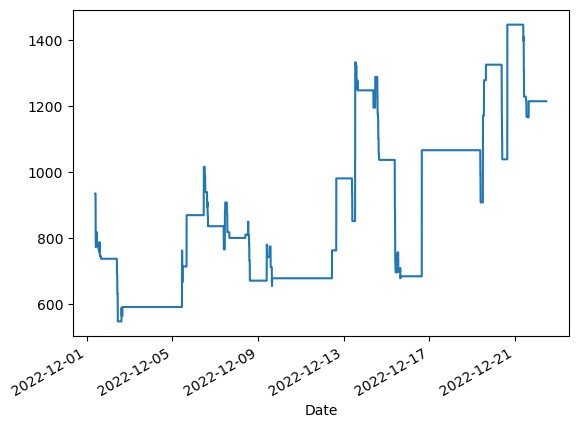

In [139]:
gain_plot_combination_return(buy_value=3,sell_value=6).loc['2022-12']['capital'].plot()

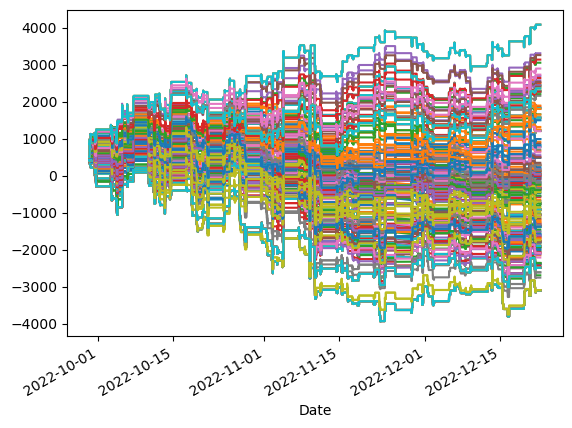

In [140]:
for i in range(-10,10):
    for j in range(-10,10):
        gain_plot_combination_return(buy_value=i,sell_value=j)['capital'].plot()

In [141]:
cum_return=[]
parameters=[]
for i in range(-10,11):
    for j in range(-10,11):
        parameters.append((i,j))
        cum_return.append(gain_plot_combination_return(buy_value=i,sell_value=j)['capital'].iloc[-1])

In [142]:
df_parameter=pd.DataFrame(columns=['parameter','cum_return'])
df_parameter

,parameter,cum_return


In [143]:
df_parameter["parameter"]=parameters
df_parameter["cum_return"]=cum_return

In [144]:
df_parameter.sort_values(by=['cum_return'],ascending=False)

,parameter,cum_return
373,"(7, 6)",4080.926514
377,"(7, 10)",4080.926514
374,"(7, 7)",4080.926514
375,"(7, 8)",4080.926514
376,"(7, 9)",4080.926514
...,...,...
207,"(-1, 8)",-3106.461334
208,"(-1, 9)",-3106.461334
209,"(-1, 10)",-3106.461334
197,"(-1, -2)",-3106.461334


In [145]:
df_parameter.sort_values(by=['cum_return'],ascending=False).to_csv('parameters_renko_any_stock.csv')

Text(0.5, 1.0, 'Amount increase in $ on investement with maximize parameter')

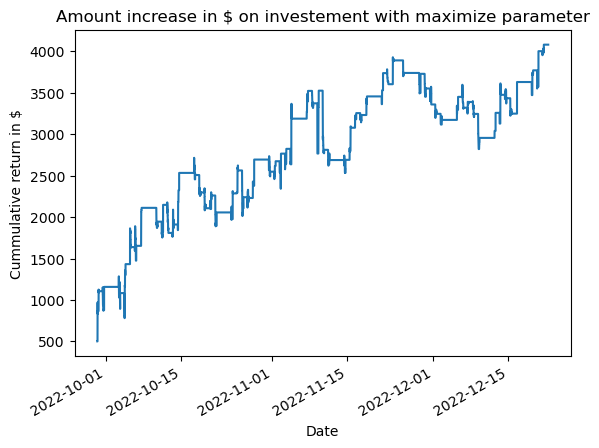

In [147]:
gain_plot_combination_return(buy_value=7,sell_value=6)['capital'].plot()
plt.ylabel("Cummulative return in $")
plt.title("Amount increase in $ on investement with maximize parameter")

Text(0, 0.5, 'Cummulative Gain in $')

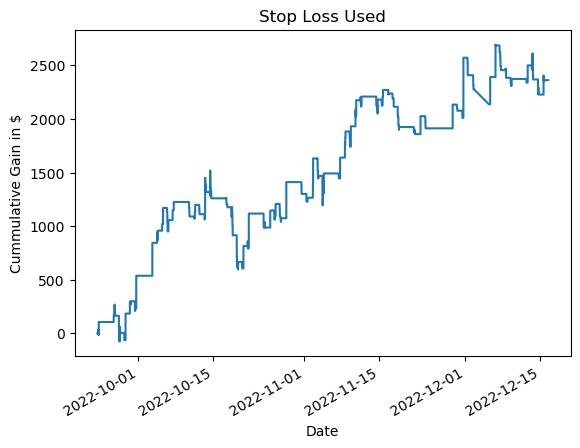

In [29]:
gain_plot_combination_return(buy_value=3,sell_value=-3)['cum_return_dollar'].plot()
plt.title('Stop Loss Used')
plt.ylabel('Cummulative Gain in $')

<AxesSubplot:xlabel='Date'>

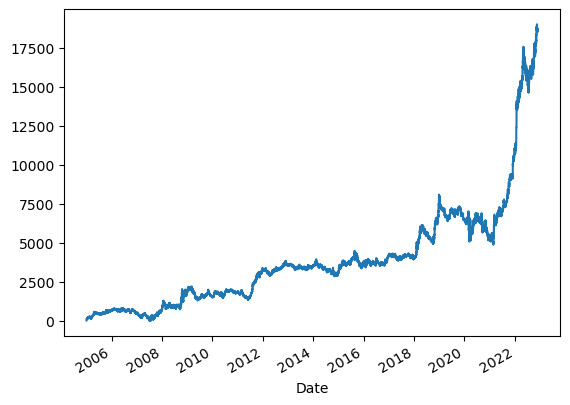

In [25]:
gain_plot_combination_return(buy_value=3,sell_value=3)['cum_return_dollar'].plot()
plt.title('')

<AxesSubplot:xlabel='Date'>

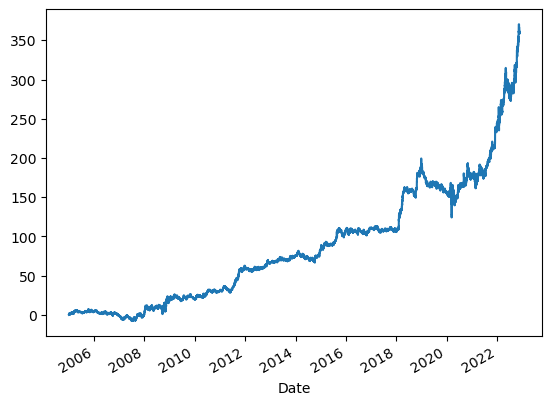

In [33]:
 gain_plot_combination_return(buy_value=3,sell_value=-1)['cum_return'].plot()

In [ ]:
spy['90']

In [26]:
gain_plot_combination_return(buy_value=3,sell_value=3).to_csv("Renko_DayTrading.csv")

In [28]:
renko_gain=gain_plot_combination_return(buy_value=3,sell_value=3)

/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_76883/1593290445.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  renko_gain['2022']["cum_return"].plot()


<AxesSubplot:xlabel='Date'>

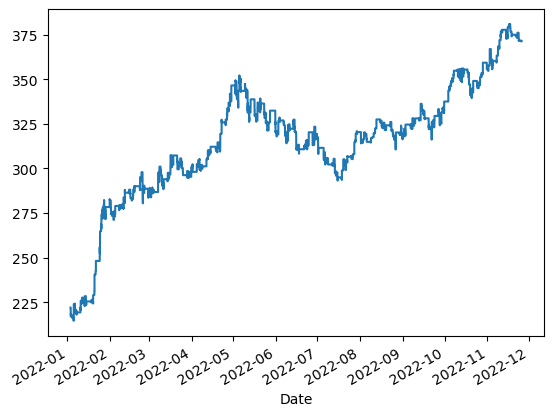

In [32]:
renko_gain['2022']["cum_return"].plot()


/var/folders/0d/2q3_g9bj7tn1m1t1w5crmtvh0000gn/T/ipykernel_76883/349889476.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  spy['2022']['Close'].plot()


<AxesSubplot:xlabel='Date'>

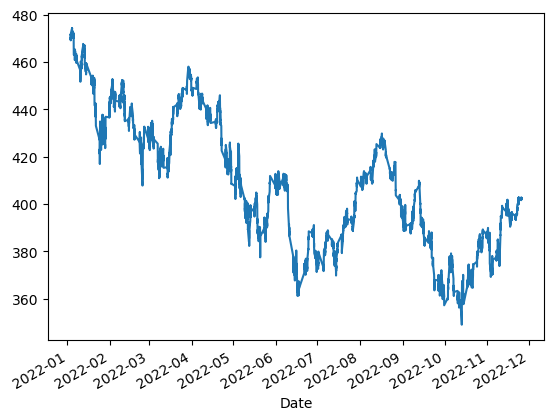

In [33]:
spy['2022']['Close'].plot()

In [92]:
# Performance Evaluation

In [98]:
CAGR(gain_plot_combination_return(buy_value=3,sell_value=-3))

0.21696952459837848

In [99]:
volatility(gain_plot_combination_return(buy_value=3,sell_value=-3))

2.204696969008448

In [100]:
sharpe(gain_plot_combination_return(buy_value=3,sell_value=-3),0.025)

0.08707297524190633

In [101]:
max_dd(gain_plot_combination_return(buy_value=3,sell_value=-3))

0.9771260931767914